In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.eval_measures import rmse
plt.style.use('seaborn')

C:\Users\liuwe\AppData\Local\Temp/ipykernel_13568/1770334321.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [38]:
df_long = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(432)', header=3, index_col=1, skiprows=range(4,5), parse_dates=['Date'])
df_short= pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/New_LSR/211213_根岸LSR平衡還流沸点データ.xlsx",
                     sheet_name='DataBase(122)', header=3, index_col=1, skiprows=range(4,5), parse_dates=['Date'])

In [43]:
df_train, df_test = df_long.iloc[:315,:], df_short
df_total = pd.concat((df_train, df_test))
df_total.pop('ID')

Date
2006-11-15 09:00:00      1
2006-12-04 09:00:00      2
2006-12-05 06:00:00      3
2006-12-07 06:00:00      4
2006-12-11 06:00:00      5
                      ... 
2021-01-27 06:00:00    118
2021-02-26 06:00:00    119
2021-03-23 06:00:00    120
2021-04-27 06:00:00    121
2021-05-25 06:00:00    122
Name: ID, Length: 437, dtype: int64

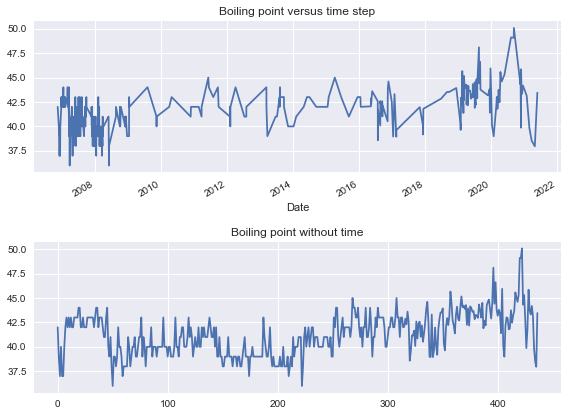

In [139]:
fig, axes = plt.subplots(2,1,figsize=(8,6))
# Visualization of the boiling point with corresponding timestep
df_total['bp'].plot(ax=axes[0], title='Boiling point versus time step')

# Visualization of the boiling point without time
axes[1].plot(np.arange(df_total.shape[0]), df_total['bp'])
axes[1].set_title('Boiling point without time')
plt.tight_layout()

In [10]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

In [104]:
def mae(y,yh):
    return np.mean(np.abs(y-yh))

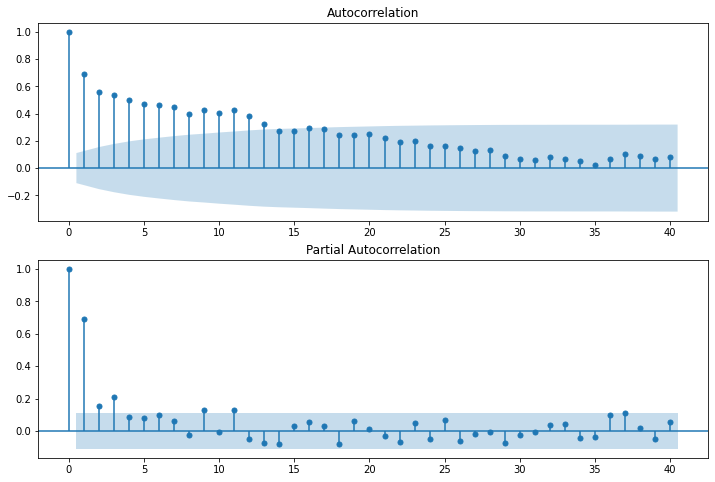

In [73]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_total['bp'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_total['bp'], lags=40, ax=ax2)

In [71]:
y_train = df_total[df_total.index < '2016/5/1 6:00:00']
y_test  = df_total[df_total.index >= '2016/5/11 6:00:00']

In [297]:
arima210 = ARIMA(df_train['bp'], order=(12,1,1))
result = arima210.fit()

C:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [298]:
result.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.1521,0.741,-0.205,0.837,-1.605,1.300
ar.L2,-0.3221,0.348,-0.925,0.355,-1.005,0.360
ar.L3,-0.1551,0.353,-0.440,0.660,-0.847,0.536
ar.L4,-0.1839,0.233,-0.791,0.429,-0.640,0.272
ar.L5,-0.1697,0.227,-0.748,0.455,-0.614,0.275
ar.L6,-0.1172,0.209,-0.560,0.576,-0.528,0.293
ar.L7,-0.0370,0.174,-0.212,0.832,-0.379,0.305
ar.L8,-0.1630,0.101,-1.621,0.105,-0.360,0.034
ar.L9,0.0247,0.160,0.154,0.878,-0.290,0.339
ar.L10,-0.0812,0.076,-1.072,0.284,-0.230,0.067


C:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


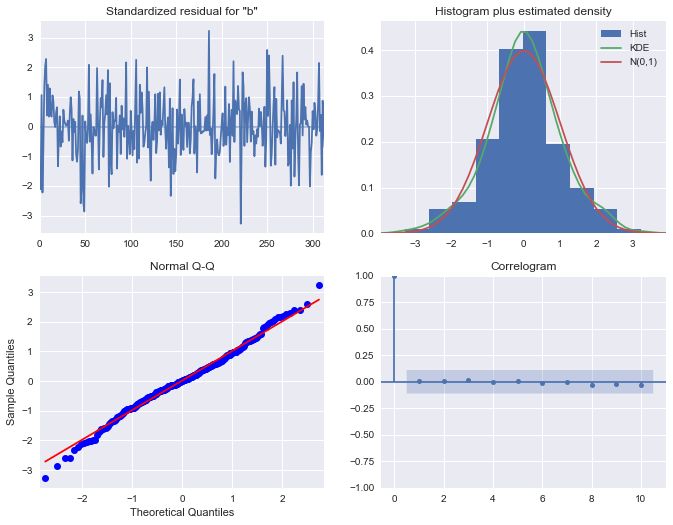

In [299]:
result.plot_diagnostics(figsize=(10,8))
plt.show()

In [300]:
ytrhat = result.predict()
ytehat = result.forecast(steps=df_test.shape[0])
print("Train RMSE: %.4f \nTrain MAE: %.4f" % (rmse(df_train['bp'],ytrhat),mae(df_train['bp'],ytrhat)))
print("Test RMSE: %.4f \nTest MAE: %.4f  " % (rmse(df_test['bp'],ytehat),mae(df_test['bp'],ytehat.values)))

Train RMSE: 2.6658 
Train MAE: 1.0619
Test RMSE: 2.1195 
Test MAE: 1.5812  


C:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


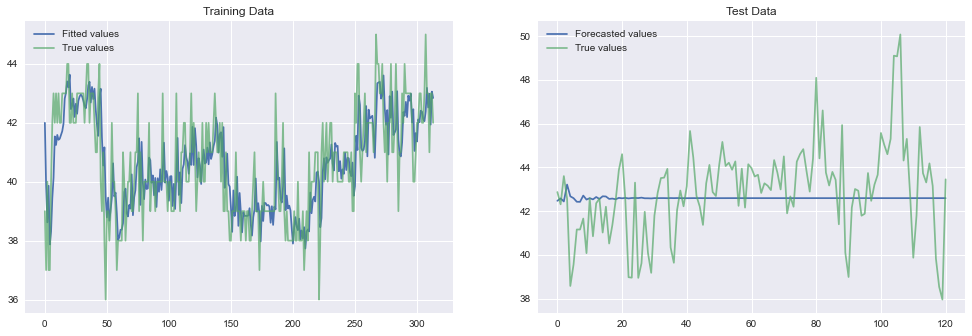

In [301]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# plt.plot(ytehat.values)
# plt.plot(df_test['bp'].values)

axes[0].plot(ytrhat.values[1:], label='Fitted values', alpha=1)
axes[0].plot(df_train['bp'].values[1:], label='True values', alpha=0.7)
axes[0].set_title('Training Data')
axes[0].legend()

axes[1].plot(ytehat.values[1:], label='Forecasted values', alpha=1)
axes[1].plot(df_test['bp'].values[1:], label='True values', alpha=0.7)
axes[1].set_title('Test Data')
axes[1].legend()

In [162]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
# Vector autoregression model
scaler = StandardScaler()
scaler.fit(df_total.iloc[:315,1:13])
df_total.iloc[:,1:13] = scaler.transform(df_total.iloc[:,1:13])

In [283]:
model = VAR(df_total.iloc[:315,:13])
results = model.fit(15)

C:\Users\liuwe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [284]:
lag_order = results.k_ar
start = 315-lag_order
forecast = results.forecast(df_total.iloc[start:315,:13].values, df_test.shape[0])
predicted = results.fittedvalues

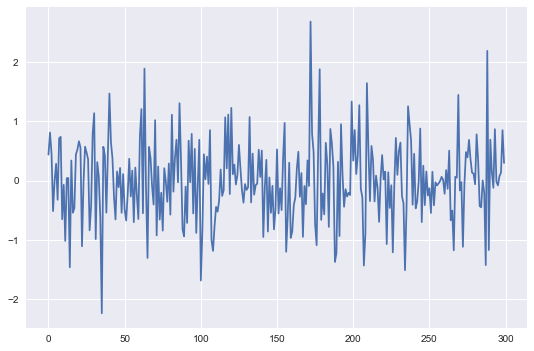

In [285]:
plt.plot(results.resid.iloc[:,0].values)

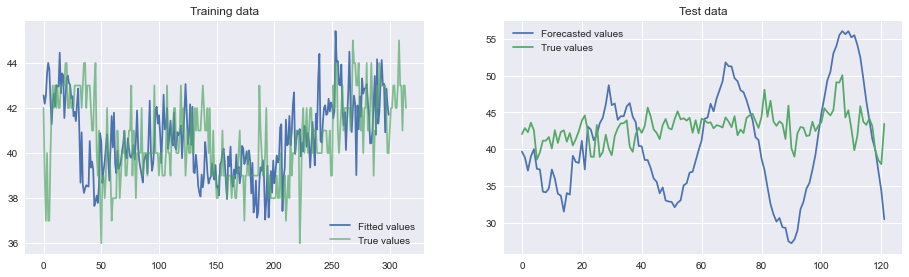

In [286]:
fig, axes = plt.subplots(1,2,figsize=(14,4))
axes[0].plot(predicted.iloc[:,0].values, label='Fitted values')
axes[0].plot(df_total['bp'][:315].values, label='True values',alpha=0.7)
axes[0].set_title('Training data')
axes[0].legend()

axes[1].plot(forecast[:,0], label='Forecasted values')
axes[1].plot(df_total['bp'][315:].values, label='True values')
axes[1].set_title('Test data')
axes[1].legend()

In [269]:
order_select = model.select_order(15)

In [ ]:
# Kalman Filter